<a href="https://colab.research.google.com/github/Codamaze/OilSpillDetection/blob/main/OilSpill_Unet18_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


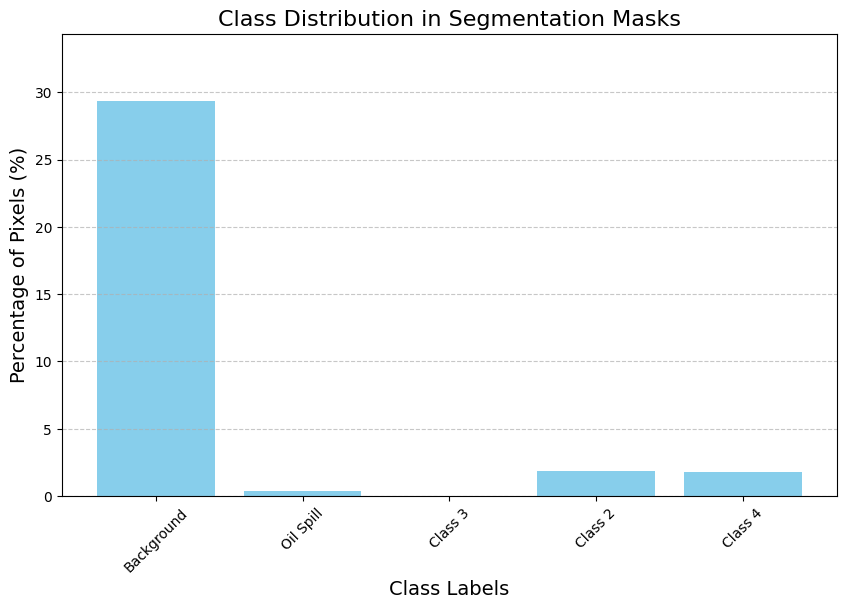

Class Weights and Colors:
Class Background: Weight = 0.6817533399695173, Color = (0, 0, 0)
Class Oil Spill: Weight = 59.802326854172144, Color = (0, 255, 255)
Class Class 3: Weight = 1389.3699889323523, Color = (153, 76, 0)
Class Class 2: Weight = 10.620097447870142, Color = (255, 0, 0)
Class Class 4: Weight = 11.330430207719271, Color = (0, 153, 0)


In [ ]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

# Define the path to your dataset
mask_dir = "/content/drive/MyDrive/oil-spill/train/labels"  # Update this with the folder containing segmentation masks

# Define the RGB values for each class
class_colors = {
    'Background': (0, 0, 0),
    'Oil Spill': (0, 255, 255),
    'Class 2': (255, 0, 0),
    'Class 3': (153, 76, 0),
    'Class 4': (0, 153, 0)
}

# Initialize counters and total pixel count
class_counts = defaultdict(int)
total_pixels = 0

# Convert class_colors to a list of RGB tuples and class names
color_list = list(class_colors.values())
class_names = list(class_colors.keys())

# Iterate through the mask files
for mask_file in os.listdir(mask_dir):
    mask_path = os.path.join(mask_dir, mask_file)

    # Load the mask image
    mask = np.array(Image.open(mask_path))  # Assuming masks are stored as RGB images (e.g., PNG)

    # Reshape mask to (H*W, 3) for vectorized comparison
    mask_reshaped = mask.reshape(-1, 3)

    # Convert the color mapping to a NumPy array for efficient broadcasting
    color_array = np.array(color_list, dtype=np.uint8)

    # Compare the reshaped mask with the color array and find matching indices
    matches = np.all(mask_reshaped[:, None, :] == color_array, axis=2)

    # Get the indices of the matching colors using argmax and convert to class names
    match_indices = np.argmax(matches, axis=1)
    matched_classes = np.array(class_names)[match_indices]

    # Count the occurrences of each class using NumPy
    unique_classes, counts = np.unique(matched_classes, return_counts=True)

    # Update the class counts from the current mask
    for cls, count in zip(unique_classes, counts):
        class_counts[cls] += count

    total_pixels += mask.size  # Count total pixels in the mask


# Calculate class weights based on pixel counts
class_weights = {}
for class_name, count in class_counts.items():
    weight = total_pixels / (len(class_colors) * count)  # Inverse frequency-based weight
    class_weights[class_name] = weight

# Prepare data for visualization
classes = list(class_counts.keys())
counts = [class_counts[class_name] for class_name in classes]
percentages = [count / total_pixels * 100 for count in counts]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(classes, percentages, color='skyblue')
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Percentage of Pixels (%)", fontsize=14)
plt.title("Class Distribution in Segmentation Masks", fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, max(percentages) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print the class weights and corresponding colors
print("Class Weights and Colors:")
for class_name, weight in class_weights.items():
    color = class_colors.get(class_name, "Unknown")
    print(f"Class {class_name}: Weight = {weight}, Color = {color}")

In [ ]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from albumentations import Compose, RandomCrop, HorizontalFlip, Rotate, GaussNoise, RandomBrightnessContrast, HueSaturationValue
from albumentations.pytorch import ToTensorV2
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define color-to-class mapping (RGB values for each class)
COLOR_MAP = [
    [0, 0, 0],        # Class 0: Black
    [0, 255, 255],    # Class 1: Cyan
    [153, 76, 0],      # Class 2: Brown
    [255, 0, 0],     # Class 3: Red
    [0, 153, 0],      # Class 4: Green
]

def process_mask(rgb_mask, colormap):
    """
    Converts an RGB mask to a one-hot encoded class mask using the provided colormap.
    Args:
        rgb_mask: RGB mask (H, W, 3)
        colormap: List of RGB values for each class.
    Returns:
        One-hot encoded mask (H, W, num_classes)
    """
    output_mask = []
    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1).astype(np.uint8)  # Check if pixel matches color and cast to uint8
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)  # Stack the individual class masks to create a one-hot mask
    return output_mask

# Define the augmentation pipeline
transform = Compose([
    RandomCrop(height=256, width=256),             # Random cropping
    HorizontalFlip(p=0.5),                         # Horizontal flipping
    Rotate(limit=30, p=0.5),                       # Random rotation
    HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),  # Adjust colors slightly
    RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Mild adjustments
    ToTensorV2(),                      # Convert to PyTorch tensors
])

# Dataset class
class MultiClassOilSpillDataset(Dataset):
    def __init__(self, image_dir, mask_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.color_mapping = color_mapping
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Read unchanged for SAR images

        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Ensure RGB format

        ''' to apply visulaisation
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Raw Image")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_rgb)
        plt.title("Raw Mask")

        plt.show()'''

        # Load image and mask
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load SAR image as is
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)      # Load mask as RGB

        # Validate data
        if image is None or mask is None:
            raise FileNotFoundError(f"Missing file: {img_path} or {mask_path}")

        # Normalize SAR image dynamically
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = image.astype(np.float32) # Cast the image to float32


        # Resize image and mask
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Convert mask to class indices
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        processed_mask = process_mask(mask, self.color_mapping)

        # Apply augmentations if specified
        if self.transform:
            augmented = self.transform(image=image, mask=processed_mask)
            image = augmented['image']
            mask = augmented['mask']

            image = np.clip(image, 0, 1)

        return image, mask



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


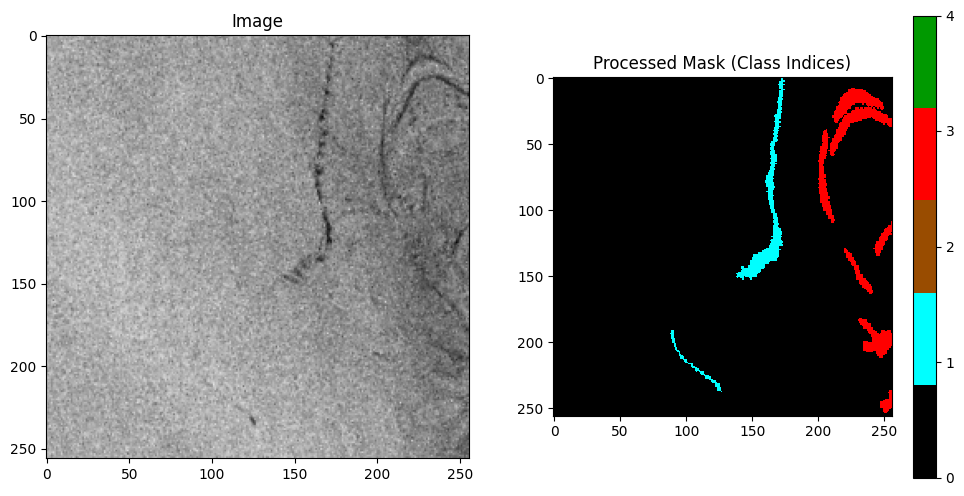

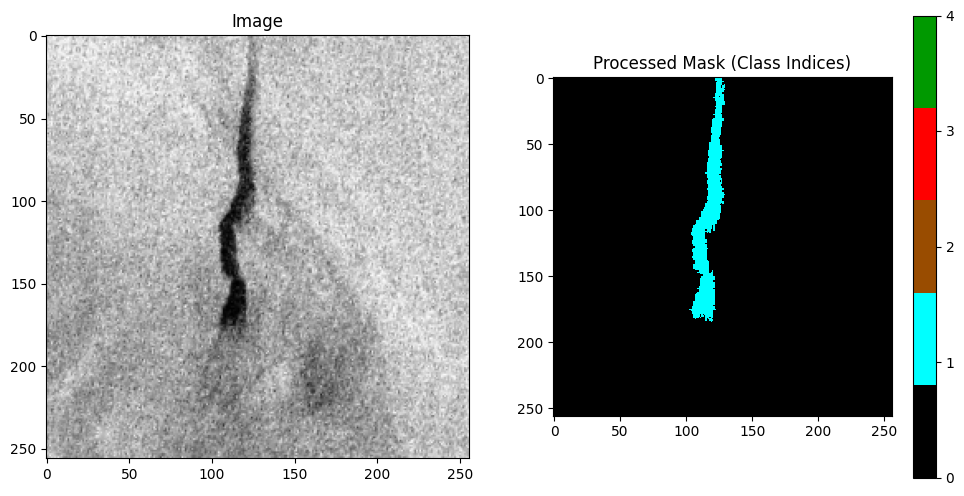

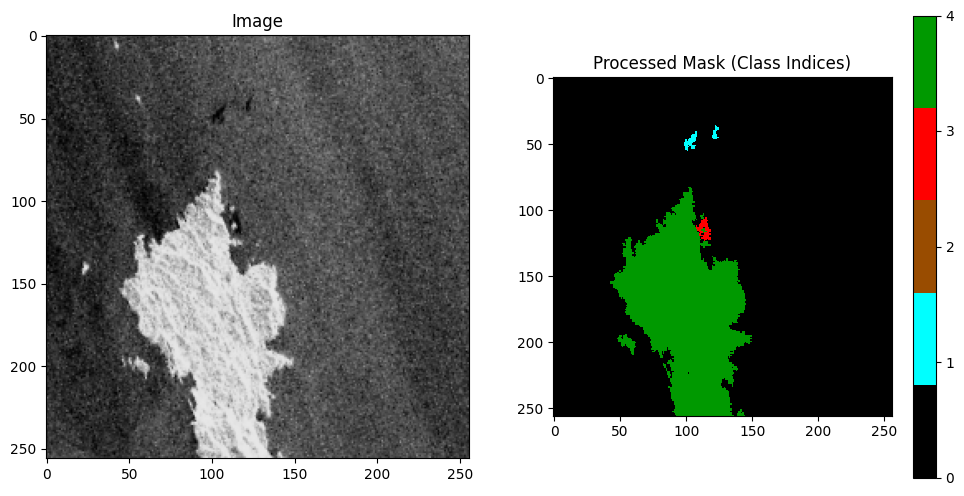

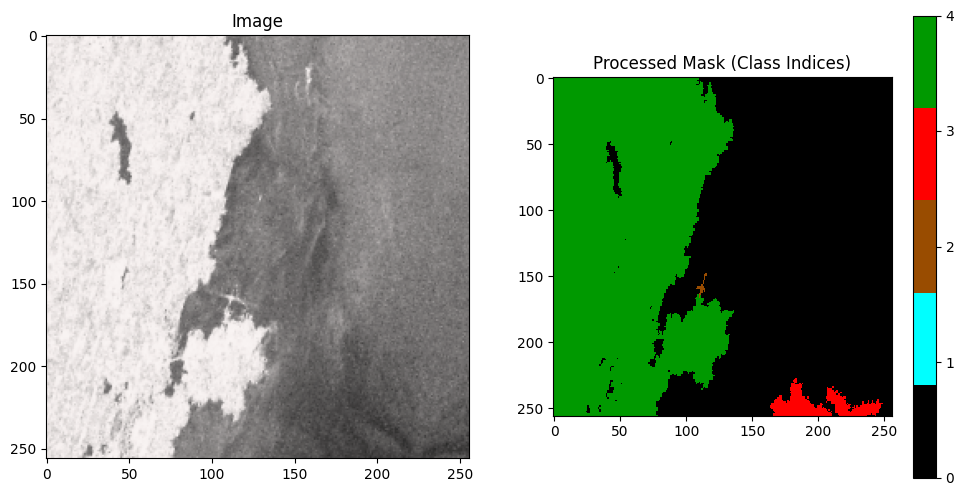

In [ ]:
# Visualize the dataset
def visualize_dataset(dataset, num_images_to_plot=5):
    # Define the color map for the classes
    scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]
    cmap = mcolors.ListedColormap(scaled_color_map)

    for i in range(num_images_to_plot):
        image, mask = dataset[i]

        # Convert image back to (H, W, C) for plotting, and denormalize the image for display
        image = image.permute(1, 2, 0).numpy() * 255  # Rescale to [0, 255]
        image = np.clip(image, 0, 255).astype(np.uint8)  # Ensure valid range

        # Get the class indices from the one-hot encoded mask
        mask_class_indices = np.argmax(mask, axis=-1)

        # Plot the image and corresponding mask
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image)  # Display the image
        plt.title("Image")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_class_indices, cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
        plt.colorbar(ticks=range(len(COLOR_MAP)))
        plt.title("Processed Mask (Class Indices)")

        plt.show()

# Define paths for your dataset (update with actual paths)
train_image_dir = '/content/drive/MyDrive/oil-spill/train/images'
train_mask_dir = '/content/drive/MyDrive/oil-spill/train/labels'


# Create the dataset
train_dataset = MultiClassOilSpillDataset(train_image_dir, train_mask_dir, COLOR_MAP, transform)

# Visualize some images and their masks
visualize_dataset(train_dataset, num_images_to_plot=4)

In [ ]:
#Calculation dice coeffcient for loss
import torch.nn as nn
def dice_loss(pred, target, smooth=1):
    pred = torch.softmax(pred, dim=1)  # Apply softmax to predictions
    target_one_hot = torch.eye(pred.shape[1], device=pred.device)[target].permute(0, 3, 1, 2).to(pred.device)
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

#to use combination of dice coefficient and CrossEntropyloss
class CombinedLoss(nn.Module):
    def __init__(self, class_weights):
        super(CombinedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, pred, target):
        ce_loss = self.cross_entropy(pred, target)
        d_loss = dice_loss(pred, target)
        return ce_loss + d_loss


In [ ]:
# Functions to compute mean IOU and accuracy
def compute_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        if union == 0:
            ious.append(0.0)  # Perfect IoU for empty class
        else:
            ious.append(intersection / (union + 1e-8))
    return np.mean(ious)

def compute_accuracy(pred, target):
    """
    Computes the accuracy of the predictions.

    Args:
        pred: Predicted logits from the model (N, C, H, W).
        target: Ground truth class indices (N, H, W).

    Returns:
        Accuracy as a float.
    """
    pred_classes = torch.argmax(pred, dim=1)
    correct = (pred_classes == target).sum().float()
    total = target.numel()
    return (correct / total).item()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.resnet import resnet18
from torchvision.models.resnet import ResNet18_Weights


class UNetResNet18(nn.Module):
    def __init__(self, input_channels, IMG_CLASSES):
        super(UNetResNet18, self).__init__()

        # ResNet18 as the encoder (feature extractor)
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Remove the fully connected layer and the classification layer
        self.encoder = nn.Sequential(
            resnet.conv1,  # c1
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1, # c2
            resnet.layer2, # c3
            resnet.layer3, # c4
            resnet.layer4  # c5
        )

        # Decoder blocks (matching the original U-Net structure)
        self.upconv4 = self.upconv_block(512, 256)
        self.upconv3 = self.upconv_block(256 + 256, 128)  # Concatenate with c4
        self.upconv2 = self.upconv_block(128 + 128, 64)   # Concatenate with c3
        self.upconv1 = self.upconv_block(64 + 64, 32)     # Concatenate with c2

        # Final convolution to output IMG_CLASSES channels
        self.final_conv = nn.Conv2d(32, IMG_CLASSES, kernel_size=1)

    def forward(self, x):
        # Encoder forward pass (ResNet18 backbone)
        c1 = self.encoder[0:4](x)    # Conv1 to maxpool
        c2 = self.encoder[4](c1)     # Layer1 (64 channels -> 64)
        c3 = self.encoder[5](c2)     # Layer2 (128 channels -> 128)
        c4 = self.encoder[6](c3)     # Layer3 (256 channels -> 256)
        c5 = self.encoder[7](c4)     # Layer4 (512 channels -> 512)

        # Decoder forward pass (Upsample and concatenate with encoder layers)
        u4 = self.upconv4(c5)
        u3 = self.upconv3(torch.cat([u4, c4], dim=1))  # Skip connection with c4
        u2 = self.upconv2(torch.cat([u3, c3], dim=1))  # Skip connection with c3
        u1 = self.upconv1(torch.cat([u2, c2], dim=1))  # Skip connection with c2

        # Final output layer
        out = self.final_conv(u1)
        return out

    def upconv_block(self, in_channels, out_channels):
        """ Upsampling block (ConvTranspose + Conv2d) """
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )


In [ ]:
if __name__ == "__main__":
    # Initialize the model with the number of output classes
    model = UNetResNet18(input_channels=3, IMG_CLASSES=5)  # 5 classes for segmentation

    # Create a random input tensor with the shape [batch_size, channels, height, width]
    x = torch.randn(1, 3, 256, 256)  # Example input (batch size 1, RGB image, 256x256)

    # Pass the input through the model
    output = model(x)

    # Print the output shape
    print(f"Output shape: {output.shape}")


Output shape: torch.Size([1, 5, 128, 128])


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3 ):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # Example class weights (modify according to your dataset)
    class_weights = torch.tensor([0.6817533399695173, 59.802326854172144 , 1389.3699889323523, 10.620097447870142, 11.330430207719271 ]).to(device)

    # Assuming `CombinedLoss` is defined elsewhere
    criterion = CombinedLoss(class_weights)  # Modify this to match your loss class
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    best_val_iou = float('inf')
    epochs_without_improvement = 0

    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_iou": [],
        "val_iou": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training Phase
        model.train()
        train_loss = 0
        train_iou = 0
        train_accuracy=0
        train_progress = tqdm(train_loader, desc="Training", unit="batch")
        for images, masks in train_progress:
            images, masks = images.to(device), masks.to(device)

            # Permute one-hot encoded masks to (N, C, H, W)
            masks = masks.permute(0, 3, 1, 2)  # From (N, H, W, C) to (N, C, H, W)

            # Get the model's output
            outputs = model(images)

            # Resize the masks to match the model's output size dynamically
            masks_resized = F.interpolate(masks.float(), size=outputs.shape[2:], mode='nearest')

            # Convert masks from one-hot encoding to class indices for the loss function
            masks_resized = torch.argmax(masks_resized, dim=1).long()  # Shape: (N, H, W)

            optimizer.zero_grad()
            loss = criterion(outputs, masks_resized)  # Loss expects class indices, not one-hot encoding

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
            optimizer.step()

            train_loss += loss.item()
            train_iou += compute_iou(outputs, masks_resized, num_classes=5)
            train_accuracy += compute_accuracy(outputs, masks_resized)
            train_progress.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        metrics["train_loss"].append(avg_train_loss)
        metrics["train_iou"].append(avg_train_iou)
        metrics["train_accuracy"].append(avg_train_accuracy)
        print(f"Training Loss: {avg_train_loss:.4f}, Training IoU: {avg_train_iou:.4f}, Training Accuracy: {avg_train_accuracy:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0
        val_iou = 0
        val_accuracy=0
        val_progress = tqdm(val_loader, desc="Validation", unit="batch")
        with torch.no_grad():
            for images, masks in val_progress:
                images, masks = images.to(device), masks.to(device)

                # Permute one-hot encoded masks to (N, C, H, W)
                masks = masks.permute(0, 3, 1, 2)  # From (N, H, W, C) to (N, C, H, W)

                # Get the model's output
                outputs = model(images)

                # Resize the masks to match the model's output size dynamically
                masks_resized = F.interpolate(masks.float(), size=outputs.shape[2:], mode='nearest')

                # Convert masks from one-hot encoding to class indices for the loss function
                masks_resized = torch.argmax(masks_resized, dim=1).long()  # Shape: (N, H, W)

                loss = criterion(outputs, masks_resized)  # Loss expects class indices, not one-hot encoding

                val_loss += loss.item()
                val_accuracy += compute_accuracy(outputs, masks_resized)
                val_iou += compute_iou(outputs, masks_resized, num_classes=5)
                val_progress.set_postfix(loss=loss.item())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        metrics["val_loss"].append(avg_val_loss)
        metrics["val_iou"].append(avg_val_iou)
        metrics["val_accuracy"].append(avg_val_accuracy)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation IoU: {avg_val_iou:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")


        # Use IoU to adjust learning rate based on validation performance
        scheduler.step(avg_val_loss)

        '''# Early Stopping
        if avg_val_iou < best_val_iou:
            best_val_iou = avg_val_iou
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_unet.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break'''

          # Save the model after training is complete
        save_path = 'unetresnet18.pth'
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")


    return metrics


In [ ]:
from torch.utils.data import DataLoader, random_split

# Paths to dataset
image_dir = "/content/drive/MyDrive/oil-spill/train/images"
mask_dir = "/content/drive/MyDrive/oil-spill/train/labels"

dataset = MultiClassOilSpillDataset(image_dir, mask_dir, COLOR_MAP, transform=transform)

# Split dataset
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Initialize models
num_classes = len(COLOR_MAP)  # Number of classes
unet_model = UNetResNet18(input_channels=3, IMG_CLASSES=5)


# Train UNet
print("Training UNet...")
train_metrics = train_model(unet_model, train_loader, val_loader, num_epochs=100, lr=1e-3)
#model.load_state_dict(torch.load('unetresnet18.pth'))

Training UNet...
Epoch 1/100


Training:   0%|          | 0/57 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=2.07]


Training Loss: 2.1524, Training IoU: 0.1807, Training Accuracy: 0.6538


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.03batch/s, loss=2.11]


Validation Loss: 1.8523, Validation IoU: 0.1254, Validation Accuracy: 0.3499
Model saved to unetresnet18.pth
Epoch 2/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.02batch/s, loss=1.35]


Training Loss: 1.4905, Training IoU: 0.3005, Training Accuracy: 0.7608


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.09s/batch, loss=1.52]


Validation Loss: 1.5534, Validation IoU: 0.3361, Validation Accuracy: 0.7522
Model saved to unetresnet18.pth
Epoch 3/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=1.25]


Training Loss: 1.4302, Training IoU: 0.2899, Training Accuracy: 0.7379


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.18s/batch, loss=1.5]


Validation Loss: 1.4825, Validation IoU: 0.2714, Validation Accuracy: 0.6690
Model saved to unetresnet18.pth
Epoch 4/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=1.64]


Training Loss: 1.3784, Training IoU: 0.3090, Training Accuracy: 0.7598


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.17s/batch, loss=1.58]


Validation Loss: 1.4377, Validation IoU: 0.3267, Validation Accuracy: 0.7545
Model saved to unetresnet18.pth
Epoch 5/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=1.02]


Training Loss: 1.3145, Training IoU: 0.3158, Training Accuracy: 0.7533


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.10s/batch, loss=1.46]


Validation Loss: 1.4276, Validation IoU: 0.3380, Validation Accuracy: 0.7735
Model saved to unetresnet18.pth
Epoch 6/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=1.68]


Training Loss: 1.2992, Training IoU: 0.3352, Training Accuracy: 0.7849


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.01batch/s, loss=1.39]


Validation Loss: 1.4661, Validation IoU: 0.2876, Validation Accuracy: 0.7000
Model saved to unetresnet18.pth
Epoch 7/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.965]


Training Loss: 1.2620, Training IoU: 0.3425, Training Accuracy: 0.7863


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/batch, loss=1.52]


Validation Loss: 1.4180, Validation IoU: 0.3778, Validation Accuracy: 0.7912
Model saved to unetresnet18.pth
Epoch 8/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=1.46]


Training Loss: 1.2251, Training IoU: 0.3542, Training Accuracy: 0.8022


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.06s/batch, loss=1.71]


Validation Loss: 1.4776, Validation IoU: 0.2559, Validation Accuracy: 0.6267
Model saved to unetresnet18.pth
Epoch 9/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=2.01]


Training Loss: 1.2469, Training IoU: 0.3473, Training Accuracy: 0.7787


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.07s/batch, loss=1.26]


Validation Loss: 1.3308, Validation IoU: 0.3338, Validation Accuracy: 0.7742
Model saved to unetresnet18.pth
Epoch 10/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=1.11]


Training Loss: 1.1652, Training IoU: 0.3612, Training Accuracy: 0.7928


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.10s/batch, loss=2.1]


Validation Loss: 1.4646, Validation IoU: 0.4033, Validation Accuracy: 0.8897
Model saved to unetresnet18.pth
Epoch 11/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05batch/s, loss=0.882]


Training Loss: 1.1727, Training IoU: 0.3680, Training Accuracy: 0.8103


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.06s/batch, loss=1.2]


Validation Loss: 1.2155, Validation IoU: 0.3695, Validation Accuracy: 0.7773
Model saved to unetresnet18.pth
Epoch 12/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05batch/s, loss=0.91]


Training Loss: 1.1541, Training IoU: 0.3560, Training Accuracy: 0.7975


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.03batch/s, loss=1.33]


Validation Loss: 1.2201, Validation IoU: 0.3052, Validation Accuracy: 0.7142
Model saved to unetresnet18.pth
Epoch 13/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=1.01]


Training Loss: 1.1571, Training IoU: 0.3677, Training Accuracy: 0.8035


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.01batch/s, loss=1.53]


Validation Loss: 1.2637, Validation IoU: 0.3627, Validation Accuracy: 0.8166
Model saved to unetresnet18.pth
Epoch 14/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=1.38]


Training Loss: 1.1137, Training IoU: 0.3790, Training Accuracy: 0.8305


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.05batch/s, loss=1.58]


Validation Loss: 1.3589, Validation IoU: 0.2860, Validation Accuracy: 0.6726
Model saved to unetresnet18.pth
Epoch 15/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=1.28]


Training Loss: 1.1153, Training IoU: 0.3679, Training Accuracy: 0.8091


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.12batch/s, loss=1.22]


Validation Loss: 1.3053, Validation IoU: 0.3799, Validation Accuracy: 0.8536
Model saved to unetresnet18.pth
Epoch 16/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.02batch/s, loss=1.04]


Training Loss: 1.0784, Training IoU: 0.3837, Training Accuracy: 0.8272


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, loss=3.39]


Validation Loss: 2.3894, Validation IoU: 0.1945, Validation Accuracy: 0.3531
Model saved to unetresnet18.pth
Epoch 17/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=1.35]


Training Loss: 1.0774, Training IoU: 0.3750, Training Accuracy: 0.8173


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.24batch/s, loss=1.34]


Validation Loss: 1.1897, Validation IoU: 0.3223, Validation Accuracy: 0.7393
Model saved to unetresnet18.pth
Epoch 18/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/batch, loss=0.777]


Training Loss: 1.0597, Training IoU: 0.3878, Training Accuracy: 0.8218


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, loss=1.02]


Validation Loss: 1.1060, Validation IoU: 0.4087, Validation Accuracy: 0.8361
Model saved to unetresnet18.pth
Epoch 19/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/batch, loss=1.17]


Training Loss: 1.0364, Training IoU: 0.3802, Training Accuracy: 0.8203


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.28batch/s, loss=1.33]


Validation Loss: 1.1382, Validation IoU: 0.4000, Validation Accuracy: 0.8238
Model saved to unetresnet18.pth
Epoch 20/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.953]


Training Loss: 1.0485, Training IoU: 0.3868, Training Accuracy: 0.8256


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26batch/s, loss=1.67]


Validation Loss: 1.4322, Validation IoU: 0.2728, Validation Accuracy: 0.6308
Model saved to unetresnet18.pth
Epoch 21/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=1.22]


Training Loss: 1.0905, Training IoU: 0.3680, Training Accuracy: 0.8159


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26batch/s, loss=1.6]


Validation Loss: 1.4471, Validation IoU: 0.2877, Validation Accuracy: 0.6384
Model saved to unetresnet18.pth
Epoch 22/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=0.863]


Training Loss: 1.0879, Training IoU: 0.3748, Training Accuracy: 0.8200


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.00batch/s, loss=1.4]


Validation Loss: 1.1550, Validation IoU: 0.3392, Validation Accuracy: 0.7462
Model saved to unetresnet18.pth
Epoch 23/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.868]


Training Loss: 1.0337, Training IoU: 0.4102, Training Accuracy: 0.8472


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/batch, loss=2.28]


Validation Loss: 1.8479, Validation IoU: 0.2064, Validation Accuracy: 0.4320
Model saved to unetresnet18.pth
Epoch 24/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=1.2]


Training Loss: 0.9752, Training IoU: 0.4020, Training Accuracy: 0.8325


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.10s/batch, loss=1.09]


Validation Loss: 1.1545, Validation IoU: 0.4339, Validation Accuracy: 0.8794
Model saved to unetresnet18.pth
Epoch 25/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.755]


Training Loss: 0.9499, Training IoU: 0.4165, Training Accuracy: 0.8515


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.14s/batch, loss=1.96]


Validation Loss: 1.3771, Validation IoU: 0.2621, Validation Accuracy: 0.6329
Model saved to unetresnet18.pth
Epoch 26/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05batch/s, loss=0.874]


Training Loss: 0.9062, Training IoU: 0.4277, Training Accuracy: 0.8592


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.16s/batch, loss=0.931]


Validation Loss: 0.9213, Validation IoU: 0.4558, Validation Accuracy: 0.8766
Model saved to unetresnet18.pth
Epoch 27/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05batch/s, loss=0.702]


Training Loss: 0.8925, Training IoU: 0.4415, Training Accuracy: 0.8645


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.08s/batch, loss=1.05]


Validation Loss: 0.9755, Validation IoU: 0.4002, Validation Accuracy: 0.8554
Model saved to unetresnet18.pth
Epoch 28/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.734]


Training Loss: 0.9453, Training IoU: 0.4226, Training Accuracy: 0.8584


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.01batch/s, loss=0.979]


Validation Loss: 1.0609, Validation IoU: 0.3881, Validation Accuracy: 0.8233
Model saved to unetresnet18.pth
Epoch 29/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=1.86]


Training Loss: 0.8903, Training IoU: 0.4433, Training Accuracy: 0.8663


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.06batch/s, loss=1.81]


Validation Loss: 1.3111, Validation IoU: 0.3255, Validation Accuracy: 0.7348
Model saved to unetresnet18.pth
Epoch 30/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=0.672]


Training Loss: 0.8818, Training IoU: 0.4350, Training Accuracy: 0.8644


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18batch/s, loss=0.911]


Validation Loss: 0.8845, Validation IoU: 0.4371, Validation Accuracy: 0.8515
Model saved to unetresnet18.pth
Epoch 31/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.788]


Training Loss: 0.9065, Training IoU: 0.4363, Training Accuracy: 0.8532


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, loss=1.16]


Validation Loss: 1.0311, Validation IoU: 0.3803, Validation Accuracy: 0.8359
Model saved to unetresnet18.pth
Epoch 32/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.725]


Training Loss: 0.8809, Training IoU: 0.4404, Training Accuracy: 0.8665


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.27batch/s, loss=1.17]


Validation Loss: 1.0532, Validation IoU: 0.4380, Validation Accuracy: 0.8751
Model saved to unetresnet18.pth
Epoch 33/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.946]


Training Loss: 0.8466, Training IoU: 0.4490, Training Accuracy: 0.8684


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=2.71]


Validation Loss: 2.0436, Validation IoU: 0.2246, Validation Accuracy: 0.5232
Model saved to unetresnet18.pth
Epoch 34/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=0.973]


Training Loss: 0.8940, Training IoU: 0.4392, Training Accuracy: 0.8635


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26batch/s, loss=0.938]


Validation Loss: 0.9358, Validation IoU: 0.4319, Validation Accuracy: 0.8463
Model saved to unetresnet18.pth
Epoch 35/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=0.764]


Training Loss: 0.8343, Training IoU: 0.4516, Training Accuracy: 0.8751


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.24batch/s, loss=1.17]


Validation Loss: 1.0348, Validation IoU: 0.3678, Validation Accuracy: 0.8085
Model saved to unetresnet18.pth
Epoch 36/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.89]


Training Loss: 0.8369, Training IoU: 0.4438, Training Accuracy: 0.8686


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.23batch/s, loss=0.875]


Validation Loss: 0.9654, Validation IoU: 0.4114, Validation Accuracy: 0.8010
Model saved to unetresnet18.pth
Epoch 37/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=0.802]


Training Loss: 0.8440, Training IoU: 0.4727, Training Accuracy: 0.8805


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.23batch/s, loss=1.08]


Validation Loss: 0.8984, Validation IoU: 0.4343, Validation Accuracy: 0.8731
Model saved to unetresnet18.pth
Epoch 38/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.02batch/s, loss=0.602]


Training Loss: 0.7811, Training IoU: 0.4809, Training Accuracy: 0.8849


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=0.893]


Validation Loss: 0.9396, Validation IoU: 0.4412, Validation Accuracy: 0.8765
Model saved to unetresnet18.pth
Epoch 39/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.584]


Training Loss: 0.7515, Training IoU: 0.4781, Training Accuracy: 0.8891


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=1.24]


Validation Loss: 0.8889, Validation IoU: 0.4626, Validation Accuracy: 0.8761
Model saved to unetresnet18.pth
Epoch 40/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=1.11]


Training Loss: 0.7590, Training IoU: 0.4790, Training Accuracy: 0.8888


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.06batch/s, loss=0.947]


Validation Loss: 0.9494, Validation IoU: 0.4058, Validation Accuracy: 0.8082
Model saved to unetresnet18.pth
Epoch 41/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.569]


Training Loss: 0.7604, Training IoU: 0.4721, Training Accuracy: 0.8807


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.11s/batch, loss=1.29]


Validation Loss: 0.9052, Validation IoU: 0.4647, Validation Accuracy: 0.8885
Model saved to unetresnet18.pth
Epoch 42/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.921]


Training Loss: 0.7930, Training IoU: 0.4700, Training Accuracy: 0.8730


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.15s/batch, loss=1.22]


Validation Loss: 0.9066, Validation IoU: 0.4163, Validation Accuracy: 0.8454
Model saved to unetresnet18.pth
Epoch 43/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.662]


Training Loss: 0.7538, Training IoU: 0.4908, Training Accuracy: 0.8955


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.13s/batch, loss=1.3]


Validation Loss: 0.8864, Validation IoU: 0.4709, Validation Accuracy: 0.8762
Model saved to unetresnet18.pth
Epoch 44/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.58]


Training Loss: 0.7373, Training IoU: 0.4886, Training Accuracy: 0.8921


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.17s/batch, loss=1.13]


Validation Loss: 0.8432, Validation IoU: 0.4800, Validation Accuracy: 0.8953
Model saved to unetresnet18.pth
Epoch 45/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.818]


Training Loss: 0.7058, Training IoU: 0.5002, Training Accuracy: 0.8969


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.13s/batch, loss=1.16]


Validation Loss: 0.8636, Validation IoU: 0.4713, Validation Accuracy: 0.8800
Model saved to unetresnet18.pth
Epoch 46/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.754]


Training Loss: 0.7077, Training IoU: 0.5012, Training Accuracy: 0.9016


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.10s/batch, loss=1.08]


Validation Loss: 0.8267, Validation IoU: 0.4673, Validation Accuracy: 0.8847
Model saved to unetresnet18.pth
Epoch 47/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=1.21]


Training Loss: 0.6965, Training IoU: 0.5036, Training Accuracy: 0.8997


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.02s/batch, loss=1.38]


Validation Loss: 0.8969, Validation IoU: 0.4383, Validation Accuracy: 0.8600
Model saved to unetresnet18.pth
Epoch 48/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.578]


Training Loss: 0.6981, Training IoU: 0.4927, Training Accuracy: 0.8959


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.03s/batch, loss=1.35]


Validation Loss: 0.9018, Validation IoU: 0.4920, Validation Accuracy: 0.8980
Model saved to unetresnet18.pth
Epoch 49/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=1.42]


Training Loss: 0.7205, Training IoU: 0.5047, Training Accuracy: 0.9039


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.09s/batch, loss=1.01]


Validation Loss: 0.8819, Validation IoU: 0.4561, Validation Accuracy: 0.8724
Model saved to unetresnet18.pth
Epoch 50/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.925]


Training Loss: 0.7133, Training IoU: 0.4959, Training Accuracy: 0.8952


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.00s/batch, loss=1.42]


Validation Loss: 0.9532, Validation IoU: 0.4413, Validation Accuracy: 0.8800
Model saved to unetresnet18.pth
Epoch 51/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.542]


Training Loss: 0.6964, Training IoU: 0.5056, Training Accuracy: 0.9060


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/batch, loss=1.45]


Validation Loss: 1.0916, Validation IoU: 0.3915, Validation Accuracy: 0.8042
Model saved to unetresnet18.pth
Epoch 52/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.602]


Training Loss: 0.6962, Training IoU: 0.5154, Training Accuracy: 0.9003


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.01batch/s, loss=0.958]


Validation Loss: 0.8631, Validation IoU: 0.4771, Validation Accuracy: 0.8778
Model saved to unetresnet18.pth
Epoch 53/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.04batch/s, loss=0.577]


Training Loss: 0.6711, Training IoU: 0.5146, Training Accuracy: 0.9014


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.01batch/s, loss=1.05]


Validation Loss: 0.8580, Validation IoU: 0.4684, Validation Accuracy: 0.8900
Model saved to unetresnet18.pth
Epoch 54/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.478]


Training Loss: 0.7177, Training IoU: 0.5124, Training Accuracy: 0.9051


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.08s/batch, loss=0.884]


Validation Loss: 0.8434, Validation IoU: 0.4534, Validation Accuracy: 0.8832
Model saved to unetresnet18.pth
Epoch 55/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=1.3]


Training Loss: 0.6711, Training IoU: 0.5128, Training Accuracy: 0.9106


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.01s/batch, loss=1.25]


Validation Loss: 0.9308, Validation IoU: 0.4752, Validation Accuracy: 0.8927
Model saved to unetresnet18.pth
Epoch 56/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05batch/s, loss=0.564]


Training Loss: 0.6634, Training IoU: 0.5075, Training Accuracy: 0.8990


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.05batch/s, loss=0.966]


Validation Loss: 0.8346, Validation IoU: 0.4692, Validation Accuracy: 0.8743
Model saved to unetresnet18.pth
Epoch 57/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=1.43]


Training Loss: 0.6790, Training IoU: 0.5035, Training Accuracy: 0.8987


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, loss=1.14]


Validation Loss: 0.9025, Validation IoU: 0.4615, Validation Accuracy: 0.8802
Model saved to unetresnet18.pth
Epoch 58/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.654]


Training Loss: 0.6656, Training IoU: 0.5201, Training Accuracy: 0.9090


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26batch/s, loss=1.13]


Validation Loss: 1.0514, Validation IoU: 0.4556, Validation Accuracy: 0.8864
Model saved to unetresnet18.pth
Epoch 59/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=0.509]


Training Loss: 0.6791, Training IoU: 0.5079, Training Accuracy: 0.9031


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.28batch/s, loss=1.15]


Validation Loss: 0.8407, Validation IoU: 0.4625, Validation Accuracy: 0.8898
Model saved to unetresnet18.pth
Epoch 60/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=0.73]


Training Loss: 0.6745, Training IoU: 0.5111, Training Accuracy: 0.9061


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.29batch/s, loss=0.951]


Validation Loss: 0.8077, Validation IoU: 0.4640, Validation Accuracy: 0.8829
Model saved to unetresnet18.pth
Epoch 61/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.537]


Training Loss: 0.6369, Training IoU: 0.5179, Training Accuracy: 0.9070


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26batch/s, loss=0.954]


Validation Loss: 0.8263, Validation IoU: 0.4739, Validation Accuracy: 0.8857
Model saved to unetresnet18.pth
Epoch 62/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.931]


Training Loss: 0.6648, Training IoU: 0.5166, Training Accuracy: 0.9060


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.01batch/s, loss=1.14]


Validation Loss: 0.8816, Validation IoU: 0.4833, Validation Accuracy: 0.8924
Model saved to unetresnet18.pth
Epoch 63/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.04batch/s, loss=0.787]


Training Loss: 0.6534, Training IoU: 0.5149, Training Accuracy: 0.9077


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.11s/batch, loss=1.19]


Validation Loss: 0.8725, Validation IoU: 0.4751, Validation Accuracy: 0.8827
Model saved to unetresnet18.pth
Epoch 64/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.683]


Training Loss: 0.6620, Training IoU: 0.5178, Training Accuracy: 0.9084


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.14s/batch, loss=1.36]


Validation Loss: 0.8719, Validation IoU: 0.4824, Validation Accuracy: 0.8960
Model saved to unetresnet18.pth
Epoch 65/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05batch/s, loss=0.523]


Training Loss: 0.6603, Training IoU: 0.5109, Training Accuracy: 0.9024


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.14s/batch, loss=1.23]


Validation Loss: 0.8753, Validation IoU: 0.4807, Validation Accuracy: 0.8825
Model saved to unetresnet18.pth
Epoch 66/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.05batch/s, loss=0.625]


Training Loss: 0.6511, Training IoU: 0.5193, Training Accuracy: 0.9087


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.03s/batch, loss=1.01]


Validation Loss: 0.8449, Validation IoU: 0.4807, Validation Accuracy: 0.8949
Model saved to unetresnet18.pth
Epoch 67/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.76]


Training Loss: 0.6506, Training IoU: 0.5130, Training Accuracy: 0.9088


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.06batch/s, loss=1.19]


Validation Loss: 0.8882, Validation IoU: 0.4705, Validation Accuracy: 0.8912
Model saved to unetresnet18.pth
Epoch 68/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=0.663]


Training Loss: 0.6424, Training IoU: 0.5130, Training Accuracy: 0.9095


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=1.11]


Validation Loss: 0.8805, Validation IoU: 0.4814, Validation Accuracy: 0.8962
Model saved to unetresnet18.pth
Epoch 69/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.624]


Training Loss: 0.6254, Training IoU: 0.5097, Training Accuracy: 0.9094


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.27batch/s, loss=0.955]


Validation Loss: 0.8754, Validation IoU: 0.4804, Validation Accuracy: 0.8890
Model saved to unetresnet18.pth
Epoch 70/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=1.73]


Training Loss: 0.6544, Training IoU: 0.5250, Training Accuracy: 0.9124


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26batch/s, loss=1.24]


Validation Loss: 0.8563, Validation IoU: 0.4862, Validation Accuracy: 0.9037
Model saved to unetresnet18.pth
Epoch 71/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.00batch/s, loss=0.853]


Training Loss: 0.6464, Training IoU: 0.5234, Training Accuracy: 0.9083


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, loss=1.32]


Validation Loss: 0.8919, Validation IoU: 0.4871, Validation Accuracy: 0.8993
Model saved to unetresnet18.pth
Epoch 72/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=1.16]


Training Loss: 0.6468, Training IoU: 0.5126, Training Accuracy: 0.9083


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.23batch/s, loss=1.06]


Validation Loss: 0.8985, Validation IoU: 0.4867, Validation Accuracy: 0.9045
Model saved to unetresnet18.pth
Epoch 73/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=1.18]


Training Loss: 0.6493, Training IoU: 0.5216, Training Accuracy: 0.9036


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.25batch/s, loss=1.38]


Validation Loss: 0.9041, Validation IoU: 0.4948, Validation Accuracy: 0.9078
Model saved to unetresnet18.pth
Epoch 74/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.731]


Training Loss: 0.6582, Training IoU: 0.5125, Training Accuracy: 0.9056


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.03batch/s, loss=0.916]


Validation Loss: 0.8343, Validation IoU: 0.4809, Validation Accuracy: 0.8918
Model saved to unetresnet18.pth
Epoch 75/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.06batch/s, loss=0.522]


Training Loss: 0.6275, Training IoU: 0.5224, Training Accuracy: 0.9092


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.11s/batch, loss=0.959]


Validation Loss: 0.8155, Validation IoU: 0.4770, Validation Accuracy: 0.8912
Model saved to unetresnet18.pth
Epoch 76/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.611]


Training Loss: 0.6348, Training IoU: 0.5203, Training Accuracy: 0.9095


Validation: 100%|██████████| 7/7 [00:08<00:00,  1.16s/batch, loss=0.985]


Validation Loss: 0.8482, Validation IoU: 0.4855, Validation Accuracy: 0.8912
Model saved to unetresnet18.pth
Epoch 77/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.451]


Training Loss: 0.6226, Training IoU: 0.5317, Training Accuracy: 0.9114


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.13s/batch, loss=1.11]


Validation Loss: 0.8869, Validation IoU: 0.4786, Validation Accuracy: 0.8842
Model saved to unetresnet18.pth
Epoch 78/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.03batch/s, loss=0.57]


Training Loss: 0.6301, Training IoU: 0.5182, Training Accuracy: 0.9105


Validation: 100%|██████████| 7/7 [00:07<00:00,  1.05s/batch, loss=1.32]


Validation Loss: 0.8936, Validation IoU: 0.4938, Validation Accuracy: 0.9071
Model saved to unetresnet18.pth
Epoch 79/100


Training: 100%|██████████| 57/57 [00:54<00:00,  1.04batch/s, loss=0.882]


Training Loss: 0.6418, Training IoU: 0.5114, Training Accuracy: 0.9083


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.07batch/s, loss=0.951]


Validation Loss: 0.8372, Validation IoU: 0.4921, Validation Accuracy: 0.9002
Model saved to unetresnet18.pth
Epoch 80/100


Training: 100%|██████████| 57/57 [00:55<00:00,  1.02batch/s, loss=0.884]


Training Loss: 0.6440, Training IoU: 0.5135, Training Accuracy: 0.9071


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.24batch/s, loss=0.879]


Validation Loss: 0.8717, Validation IoU: 0.4791, Validation Accuracy: 0.8889
Model saved to unetresnet18.pth
Epoch 81/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=1.4]


Training Loss: 0.6419, Training IoU: 0.5149, Training Accuracy: 0.9103


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.24batch/s, loss=1.05]


Validation Loss: 0.8268, Validation IoU: 0.5002, Validation Accuracy: 0.9081
Model saved to unetresnet18.pth
Epoch 82/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.949]


Training Loss: 0.6307, Training IoU: 0.5211, Training Accuracy: 0.9101


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.28batch/s, loss=0.969]


Validation Loss: 0.8175, Validation IoU: 0.4880, Validation Accuracy: 0.8966
Model saved to unetresnet18.pth
Epoch 83/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.525]


Training Loss: 0.6407, Training IoU: 0.5194, Training Accuracy: 0.9117


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.26batch/s, loss=0.986]


Validation Loss: 0.8015, Validation IoU: 0.4891, Validation Accuracy: 0.9052
Model saved to unetresnet18.pth
Epoch 84/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/batch, loss=0.545]


Training Loss: 0.6391, Training IoU: 0.5184, Training Accuracy: 0.9108


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=1.21]


Validation Loss: 0.8483, Validation IoU: 0.4990, Validation Accuracy: 0.9093
Model saved to unetresnet18.pth
Epoch 85/100


Training: 100%|██████████| 57/57 [00:58<00:00,  1.03s/batch, loss=2.26]


Training Loss: 0.6660, Training IoU: 0.5147, Training Accuracy: 0.9083


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=1.1]


Validation Loss: 0.8414, Validation IoU: 0.4861, Validation Accuracy: 0.8972
Model saved to unetresnet18.pth
Epoch 86/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.02s/batch, loss=0.637]


Training Loss: 0.6332, Training IoU: 0.5208, Training Accuracy: 0.9096


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=1.12]


Validation Loss: 0.8828, Validation IoU: 0.4694, Validation Accuracy: 0.8850
Model saved to unetresnet18.pth
Epoch 87/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/batch, loss=1.29]


Training Loss: 0.6465, Training IoU: 0.5186, Training Accuracy: 0.9095


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s, loss=1.09]


Validation Loss: 0.8368, Validation IoU: 0.4924, Validation Accuracy: 0.9028
Model saved to unetresnet18.pth
Epoch 88/100


Training: 100%|██████████| 57/57 [00:58<00:00,  1.02s/batch, loss=0.991]


Training Loss: 0.6395, Training IoU: 0.5144, Training Accuracy: 0.9075


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=1.3]


Validation Loss: 0.8587, Validation IoU: 0.4931, Validation Accuracy: 0.9020
Model saved to unetresnet18.pth
Epoch 89/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.842]


Training Loss: 0.6274, Training IoU: 0.5214, Training Accuracy: 0.9094


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=0.956]


Validation Loss: 0.8334, Validation IoU: 0.4855, Validation Accuracy: 0.9004
Model saved to unetresnet18.pth
Epoch 90/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=0.897]


Training Loss: 0.6263, Training IoU: 0.5109, Training Accuracy: 0.9113


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.21batch/s, loss=1.31]


Validation Loss: 0.8431, Validation IoU: 0.4851, Validation Accuracy: 0.8964
Model saved to unetresnet18.pth
Epoch 91/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=1.44]


Training Loss: 0.6469, Training IoU: 0.5176, Training Accuracy: 0.9079


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.03batch/s, loss=1.18]


Validation Loss: 0.8494, Validation IoU: 0.4964, Validation Accuracy: 0.9067
Model saved to unetresnet18.pth
Epoch 92/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.528]


Training Loss: 0.6301, Training IoU: 0.5240, Training Accuracy: 0.9113


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.20batch/s, loss=1.04]


Validation Loss: 0.8028, Validation IoU: 0.4838, Validation Accuracy: 0.8991
Model saved to unetresnet18.pth
Epoch 93/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/batch, loss=0.674]


Training Loss: 0.6491, Training IoU: 0.5211, Training Accuracy: 0.9078


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.23batch/s, loss=0.859]


Validation Loss: 0.8444, Validation IoU: 0.4830, Validation Accuracy: 0.8969
Model saved to unetresnet18.pth
Epoch 94/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/batch, loss=0.707]


Training Loss: 0.6319, Training IoU: 0.5210, Training Accuracy: 0.9114


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.21batch/s, loss=1.1]


Validation Loss: 0.9023, Validation IoU: 0.4718, Validation Accuracy: 0.8835
Model saved to unetresnet18.pth
Epoch 95/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.595]


Training Loss: 0.6353, Training IoU: 0.5104, Training Accuracy: 0.9116


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.23batch/s, loss=1.43]


Validation Loss: 0.8804, Validation IoU: 0.4911, Validation Accuracy: 0.8978
Model saved to unetresnet18.pth
Epoch 96/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.01s/batch, loss=0.843]


Training Loss: 0.6456, Training IoU: 0.5119, Training Accuracy: 0.9101


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.21batch/s, loss=1.04]


Validation Loss: 0.8381, Validation IoU: 0.4856, Validation Accuracy: 0.8958
Model saved to unetresnet18.pth
Epoch 97/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.59]


Training Loss: 0.6388, Training IoU: 0.5182, Training Accuracy: 0.9108


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=1.2]


Validation Loss: 0.8684, Validation IoU: 0.4843, Validation Accuracy: 0.8975
Model saved to unetresnet18.pth
Epoch 98/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.5]


Training Loss: 0.6282, Training IoU: 0.5230, Training Accuracy: 0.9120


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=0.843]


Validation Loss: 0.8766, Validation IoU: 0.4857, Validation Accuracy: 0.8928
Model saved to unetresnet18.pth
Epoch 99/100


Training: 100%|██████████| 57/57 [00:57<00:00,  1.00s/batch, loss=0.613]


Training Loss: 0.6202, Training IoU: 0.5253, Training Accuracy: 0.9097


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s, loss=1.2]


Validation Loss: 0.8848, Validation IoU: 0.4763, Validation Accuracy: 0.8886
Model saved to unetresnet18.pth
Epoch 100/100


Training: 100%|██████████| 57/57 [00:56<00:00,  1.01batch/s, loss=1.99]


Training Loss: 0.6565, Training IoU: 0.5229, Training Accuracy: 0.9112


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s, loss=0.887]
<ipython-input-29-88194b00d967>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_di

Validation Loss: 0.8203, Validation IoU: 0.4816, Validation Accuracy: 0.8886
Model saved to unetresnet18.pth


RuntimeError: Error(s) in loading state_dict for UNetResNet18:
	Missing key(s) in state_dict: "upconv4.3.weight", "upconv4.3.bias", "upconv4.6.weight", "upconv4.6.bias", "upconv3.3.weight", "upconv3.3.bias", "upconv3.6.weight", "upconv3.6.bias", "upconv2.3.weight", "upconv2.3.bias", "upconv2.6.weight", "upconv2.6.bias", "upconv1.3.weight", "upconv1.3.bias", "upconv1.6.weight", "upconv1.6.bias". 
	Unexpected key(s) in state_dict: "upconv4.2.weight", "upconv4.2.bias", "upconv4.4.weight", "upconv4.4.bias", "upconv3.2.weight", "upconv3.2.bias", "upconv3.4.weight", "upconv3.4.bias", "upconv2.2.weight", "upconv2.2.bias", "upconv2.4.weight", "upconv2.4.bias", "upconv1.2.weight", "upconv1.2.bias", "upconv1.4.weight", "upconv1.4.bias". 

In [ ]:
# After training the model
torch.save(unet_model.state_dict(), 'unetresnet18_100.pth')


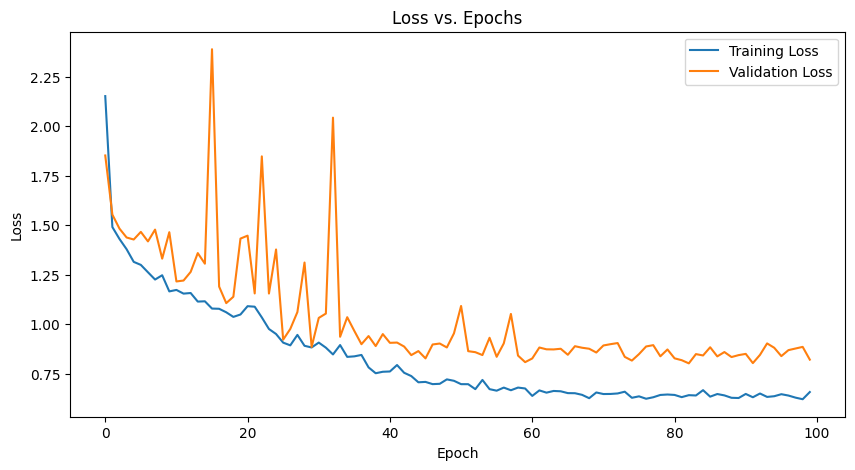

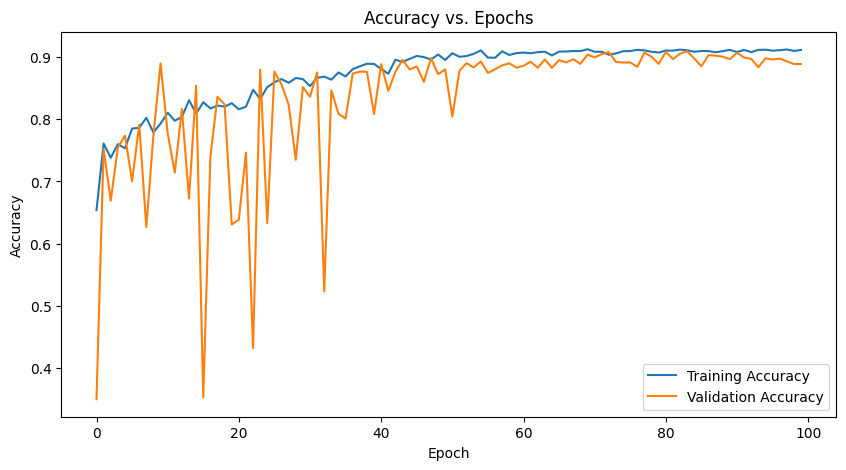

In [ ]:
import matplotlib.pyplot as plt
# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(train_metrics["train_loss"], label="Training Loss")
plt.plot(train_metrics["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(train_metrics["train_accuracy"], label="Training Accuracy")
plt.plot(train_metrics["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")
plt.show()


In [ ]:
model = UNetResNet18(input_channels=3, IMG_CLASSES=5)
model.load_state_dict(torch.load('unetresnet18_100.pth'))
model.eval()  # Set the model to evaluation mode

<ipython-input-33-822fa6b717bc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unetresnet18_100.pth'))


UNetResNet18(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=